# Radiative transfer model of Titan in Near-IR
- - - - - 

<mate@berkeley.edu>

## Introduction

This is a package for setting up the atmospheric structure of Titan and calculating near-infrared spectra. The atmospheric structure and properties of the aerosol scattering are determined using the measurements made in situ by instruments on the Huygens probe. The gas opacities are calculated from line lists in the HITRAN2012 database. Solutions to the radiative transfer can be performed with the twostream (fast) or discrete ordinates (less fast) methods. Examples of setting up the atmosphere and generating spectra are illustrated below. 

## Reference Data

Due to the size of the reference data sets, they are not stored with the code repository and can be downloaded from a [public HTML directory](http://astro.berkeley.edu/~madamkov/refdata/). 

The method is included to setup the local directory structure and download the reference files specified at the top of the refdata module. Run the following after installation.

    atmosphere.refdata.setup_directory()

## Installation

### 1. The `atmosphere` package can be installed using the standard source distribution installation 

    python setup.py install
    
After installation, which hopefully will compile [CDISORT](http://www.libradtran.org/bin/cdisort-2.1.3.tar.gz) (written by Tim Dowling, as part of [libradtran](http://www.libradtran.org/)), the path to where reference data files will go needs to be specified. 

### 2. __<span style="color:red"> Set the environment variable RTDATAPATH </span>__.

This can be done from the notebook using 

    import os
    os.environ['RTDATAPATH'] = '/path/to/your/reference/data/'

However, this environment variable will be cleaned up on exit from the interpreter, or notebook. It also won't be there when starting a new shell. It is best to edit your shell configuration file (e.g., `.bash_profile`) to include the following line:

    export RTDATAPATH = '/path/to/your/reference/data/'
    
This will also be helpful when running calculations in parallel when new processes are started.

### 3. Import the atmosphere module and get reference data, e.g., with the code below

In [1]:
import atmosphere as atm
atm.refdata.setup_directory()

Reference data exists: /Users/mate/g/rt/data/refdata/atmosphere_structure/titan/HASI_L4_ATMO_PROFILE_DESCEN.TAB
Reference data exists: /Users/mate/g/rt/data/refdata/aerosol/titan/Tomasko2007_phase_0-80km.TAB
Reference data exists: /Users/mate/g/rt/data/refdata/aerosol/titan/Tomasko2007_phase_80-200km.TAB
Reference data exists: /Users/mate/g/rt/data/refdata/gas_opacity/CIA/N2_N2.fits
Reference data exists: /Users/mate/g/rt/data/refdata/gas_opacity/CIA/H2_N2.fits
Reference data exists: /Users/mate/g/rt/data/refdata/gas_opacity/kc_CH4.SINFONI.v08.dnu_3.0.fits
Reference data exists: /Users/mate/g/rt/data/refdata/gas_opacity/kc_CH4.VIMS.v08.fits


## Example 1. Set up a model atmosphere structure

In [2]:
import os
model = atm.structure.set_HASI_structure(nlev=11,  method='split_at_tropopause')

atm.composition.set_abundances(model, trace_gas={'m_H2':0.001})

atm.gas_opacity.set_methane(
            model, kc_file=os.path.join(os.getenv('RTDATAPATH'),
                                        'gas_opacity/kc_CH4.SINFONI.v08.dnu_3.0.fits'))
atm.gas_opacity.set_cia(model)
atm.aerosol.set_opacity(model)

DISR = atm.aerosol.fit_DISR_phases()
atm.aerosol.set_aerosol_phase_moments(model, DISR, nmom=24)

view = {'umu0':0.90630776,
        'phi0':200.,
        'umue':0.96592581,
        'phie':195,}

model.update({'view':view})

### There are three ways to divide the atmosphere and set layer boundaries, illustrated below

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/matplotlib-1.5.0rc1_43.gd70ce32-py3.4-macosx-10.6-x86_64.egg/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


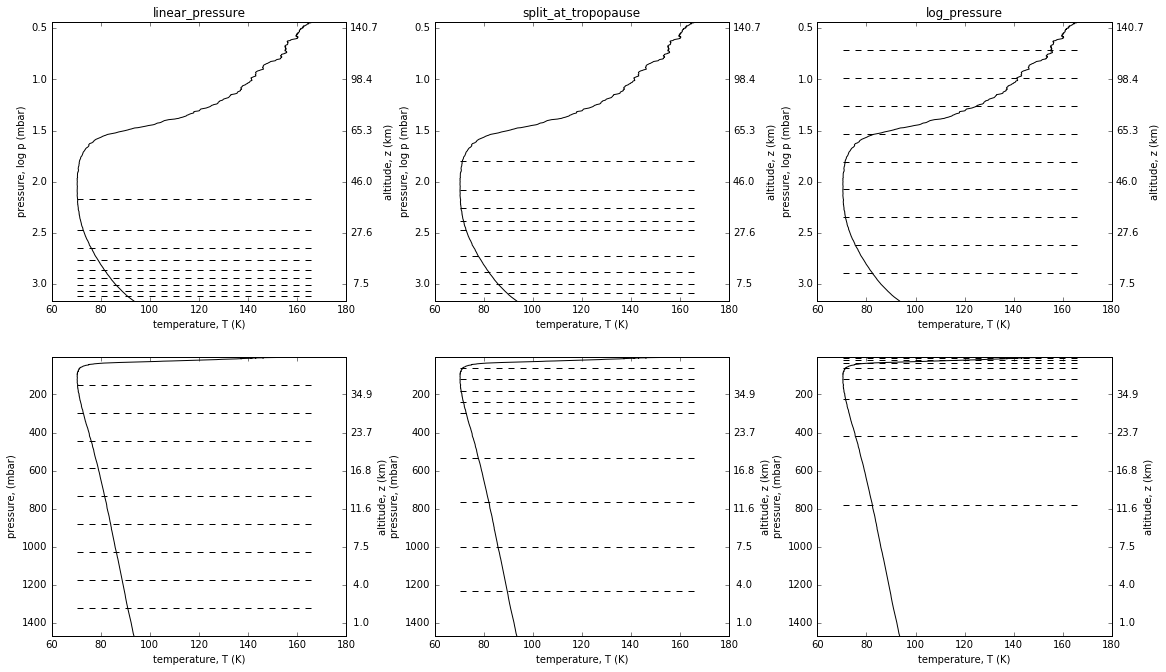

In [3]:
%matplotlib inline
atm.structure.show_atmosphere_structures(model)

## Example 2: Parallel two-stream calculation using atmosphere model

A two-stream solver (`twostream.py`) is included as a module for calculation of spectra, which is implemented using the parallel engines (or clusters). There is also an implementation of CDISORT (a.k.a., PyDISORT) which will require some cc compilation and linking. Documentation for the code is handled within the notebooks and doc strings.

<span style="color:blue"> Start engines under the IPython notebook clusters tab.  </span>

Running a two-stream calucation without parallelization is built into the module:

    from atmosphere.rt import twostream
    twostream.calc_spectrum(model, hg=0.50, mu0=pseudo_pp(0.7, model, 2575.), rsurf=0.53)

In [5]:
from IPython import parallel
engines = parallel.Client()
dv = engines[:]
dv.scatter('id', dv.targets, flatten=True)
stride = len(dv)
dv['stride'] = stride

In [6]:
def twostream_parallel(model, hg, mu0, rsurf):
    """Run two-stream calculation in parallel for
    atmosphere model and apend spectrum to data
    structure. Assumes that multiple engines are
    running in IPython notebook."""

    def calc_sub_spectrum(model, hg, mu0, rsurf):
        """Run two-stream calculation on a subset of the
        total spectral bandpass."""

        from numpy import size, zeros, empty, sum
        from atmosphere.rt import twostream    

        tau, ssa = twostream.get_opacity_ssa(model, verbose=False)
        intensities = zeros([model['nlam'], model['layers']['kc']['ng']])
        g_weight = model['layers']['kc']['w']

        chunk = model['nlam']/stride
        imn = int(id*chunk)
        imx = int((id+1)*chunk)
        
        if size(mu0) == 1:
            MU0 = empty(model['nlay']) 
            MU0.fill(mu0)
        else:
            MU0 = mu0

        for iwn in range(imn,imx):
            for g in range(model['layers']['kc']['ng']):
                tau_mono = tau[:,iwn,g]
                ssa_mono = ssa[:,iwn,g]
                g_Imu = twostream.mono(tau_mono, ssa_mono, hg, rsurf, MU0)
                intensities[iwn,g] = g_Imu[0]

        sub_spectrum = sum(intensities*g_weight, axis=1)  

        return sub_spectrum

    from numpy import zeros
    
    spectrum = zeros(model['nlam'])
    spectra = dv.apply_async(calc_sub_spectrum, model, hg, mu0, rsurf)

    for sub_spectrum in spectra.get():
        spectrum += sub_spectrum

    model.update({'spectrum':spectrum,
                'calc':{'method':'twostream_parallel',
                        'hg':hg,
                        'mu0':mu0,
                        'rsurf':rsurf,
                        }
                })
    

import time
ts = time.time()

from atmosphere.rt.twostream import pseudo_pp
twostream_parallel(model, hg=0.50, mu0=pseudo_pp(0.7, model, 2575.),  rsurf=0.53)

t_run = time.time() - ts
print('Two-stream parallel ({:d} processes) for {:d} channels: {:6.1f} sec.'.format(len(dv), model['nlam'], t_run))

Two-stream parallel (4 processes) for 1992 channels:    1.9 sec.


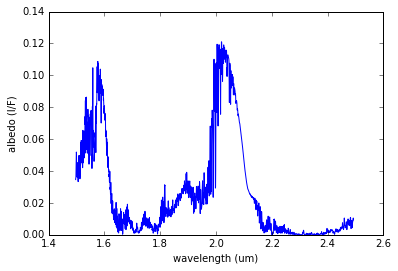

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(model['wavelength'], model['spectrum'])
ax.set_xlabel('wavelength (um)')
ax.set_ylabel('albedo (I/F)') ;

## PyDISORT in parallel

The scattering phase moments need to be calculated and interpolated onto the wavelength grid of the model so 
that CDISORT can be called and used to solve the radiative transfer.


In [8]:
def pydisort_parallel(model, rsurf, w_haze=0.96, wav_range=None):
    """Run CDISORT in parallel on notebook engines 
    using atm.rt.cdisort module. 
    
    Caluclation runs over entire wavlength range in the 
    model data structure unless abridged with the 
    optional argument:
    
    wav_range - list of two wavelenghts in micron
    """
    
    from numpy import zeros
    
    def pydisort_sub_spectrum(model, rsurf, w_haze, wav_range=wav_range) :
        """Compare FORTRAN and C DISORT Using input structure for Titan
        that was generated by IDL code: /Users/mate/data/titan/DISORT_TEST"""

        from numpy import zeros, sum, abs, ndarray, floor, mod
        from atmosphere.rt import pydisort
 
        
        mono_input = {'nlyr':model['nlay'],
                      'umu0':model['view']['umu0'],
                      'phi0':model['view']['phi0'],
                      'umue':model['view']['umue'],
                      'phie':model['view']['phie'],
                      }
        ng = model['layers']['kc']['ng']
        g_weight = model['layers']['kc']['w']
        
        fluxes, intensities = ( zeros([model['nlam'],ng]), 
                                zeros([model['nlam'],ng]))
        if wav_range:
            fi = lambda array, v: abs(array-v).argmin()
            wav_indices = lambda array, wavs: tuple([fi(array, mu) for mu in wavs])
            wav_mn, wav_mx = wav_indices(model['wavelength'], wav_range) 
            chunk = (wav_mx - wav_mn + 1)/stride
            i_mn = int(wav_mn+id*chunk)
            i_mx = int(wav_mn+(id+1)*chunk)
            mono_input.update({'i_mn':i_mn,
                               'i_mx':i_mx,})
        else:
            chunk = model['nlam']/stride
            i_mn = int(id*chunk)
            i_mx = int((id+1)*chunk)
            mono_input.update({'i_mn':i_mn,
                               'i_mx':i_mx,})
        
        tau, ssa = pydisort.get_tau_ssa(model, w_haze)
        
        for iwn in range(i_mn,i_mx):
            nmom = model['haze']['pmom']['hi'].shape[1]-1
            pmom = ndarray(model['nlay']*(nmom+1))

            for imom in range(model['nlay']*(nmom+1)):
                iz = floor(imom/(nmom+1))
                if model['layers']['z'][iz] > 80 :
                    phase_moments = model['haze']['pmom']['hi'][iwn,:]
                else:
                    phase_moments = model['haze']['pmom']['lo'][iwn,:]
                pmom[imom] = float(phase_moments[mod(imom, nmom+1)])            
                
            mono_input.update({'nstr':nmom,
                               'nmom':nmom,
                               'albedo':rsurf,
                               'pmom':pmom,
                               }
                              )
            for g in range(ng) :
                mono_input.update({'dtau':tau[:,iwn,g],
                                   'ssalb':ssa[:,iwn,g],
                                   }
                                  )

                g_flup, g_uu = pydisort.mono(mono_input)
                fluxes[iwn,g] = g_flup

        sub_spectrum = sum(fluxes*g_weight, axis=1)  
        return sub_spectrum
    
    spectrum = zeros(model['nlam'])
    spectra = dv.apply_async(pydisort_sub_spectrum, model, rsurf, w_haze)

    for sub_spectrum in spectra.get():
        spectrum += sub_spectrum

    if wav_range:
        fi = lambda array, v: abs(array-v).argmin()
        wav_indices = lambda array, wavs: tuple([fi(array, mu) for mu in wavs])
        wav_mn, wav_mx = wav_indices(model['wavelength'], wav_range) 
    else:
        wav_mn, wav_mx, nlam = 0, model['nlam'], model['nlam']
        
    model.update({'spectrum':spectrum,
                  'calc':{'method':'pydisort_parallel',
                          'rsurf':rsurf,
                          'w_haze':w_haze,
                          'wav_mn':wav_mn,
                          'wav_mx':wav_mx,
                          'wav_range':wav_range,
                          'nlam':wav_mx-wav_mn+1,
                         }
                 })

In [10]:
import time
ts = time.time()

pydisort_parallel(model, 0.05)

t_run = time.time() - ts
print('PyDISORT parallel ({:d} processes) for {:d} channels: {:6.1f} sec.'.format(len(dv), model['nlam'], t_run))

PyDISORT parallel (4 processes) for 1992 channels:   98.6 sec.


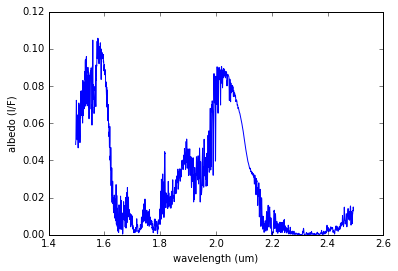

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(model['wavelength'], model['spectrum'])
ax.set_xlabel('wavelength (um)')
ax.set_ylabel('albedo (I/F)') ;